# Fine-tune BLIP using Hugging Face `transformers`, `datasets`, `peft` 🤗 and `bitsandbytes`

Let's leverage recent advances from Parameter Efficient Fine-Tuning methods to fine-tune a large image to text model! We will show through this tutorial that it is possible to fine-tune a 3B scale model (~6GB in half-precision)

Here we will use a dummy dataset of [football players](https://huggingface.co/datasets/ybelkada/football-dataset) ⚽ that is uploaded on the Hub. The images have been manually selected together with the captions. 
Check the 🤗 [documentation](https://huggingface.co/docs/datasets/image_dataset) on how to create and upload your own image-text dataset.

## Set-up environment

In [1]:
#!pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets

## Load the image captioning dataset

Let's load the image captioning dataset, you just need few lines of code for that.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

from datasets import load_dataset 
from transformers import (
    Blip2VisionConfig,
    Blip2QFormerConfig,
    OPTConfig,
    Blip2Config,
    Blip2ForConditionalGeneration,
    #PhiConfig,
    Blip2Model
)
from transformers import AutoProcessor, AutoTokenizer
import bitsandbytes
from peft import LoraConfig, get_peft_model

/home/everdistant/miniconda3/envs/final/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'image': Image(decode=True, id=None), 'text': Value(dtype='string', id=None)}

["Benzema after Real Mardid's win against PSG",
 'Maradona after winning the 1986 FIFA World Cup with Argentina',
 'Messi with Argentina at the 2022 FIFA World Cup',
 'Pirlo with Juventus in 2014',
 'Ronaldo with Portugal at the 2018 World Cup',
 'Zidane with France in 2006 World Cup']

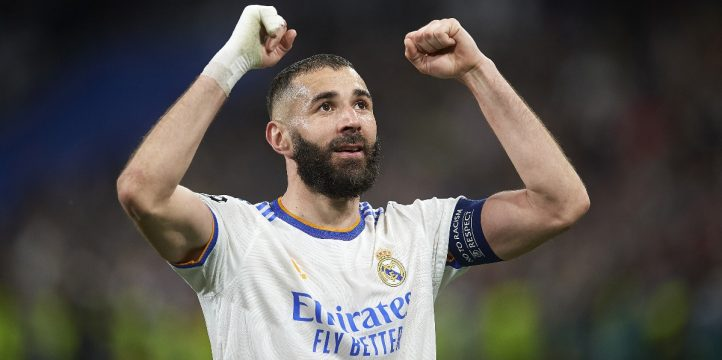

In [3]:
dataset = load_dataset("ybelkada/football-dataset", split="train")

display(dataset.features)
display(dataset['text'])
display(dataset[0]["image"])

## Create PyTorch Dataset

Let's define below the dataset as well as the data collator!

In [4]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = item["text"]
        return encoding

def collate_fn(batch):
    # pad the input_ids and attention_mask
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch


## Load model and processor

Now that we have loaded the processor, let's load the dataset and the dataloader:

In [5]:
base_model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", 
    device_map="auto", load_in_8bit=True)

# original_language_projection = base_model.language_projection
# base_model.language_projection = bitsandbytes.nn.Linear8bitLt(
#     original_language_projection.in_features, 2048).to(base_model.device)
# base_model.post_init()

model = get_peft_model(base_model, LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=[
        "crossattention.attention.query",
        "crossattention.attention.key",
        #"q_proj", 
        # "k_proj", 
        #"language_projection"

    ],
))
#model.language_projection.requires_grad = True
model.print_trainable_parameters()
display(model.language_projection)
display(model.language_model)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]

trainable params: 356,352 || all params: 3,745,036,288 || trainable%: 0.009515315008878226


Linear8bitLt(in_features=768, out_features=2560, bias=True)

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 2560, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 2560)
      (final_layer_norm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-31): 32 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
            (v_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
            (q_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
            (out_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear8bitLt(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear8bitLt(in_features=10240, out_features=2560, bias=True

Target caption: Maradona after winning the 1986 FIFA World Cup with Argentina


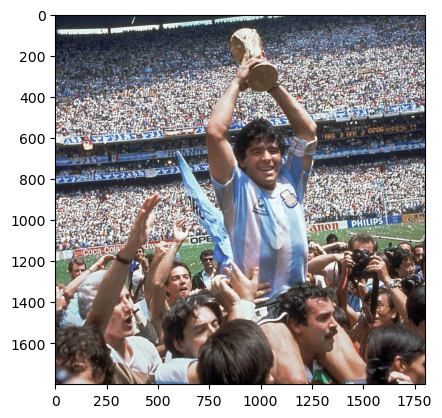

In [6]:
IDX = 1

example = dataset[IDX]
print(f"Target caption: {dataset['text'][IDX]}")
example_image = example["image"]
plt.imshow(example_image)

## Train the model

In [7]:
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=3, collate_fn=collate_fn)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Target caption: {dataset['text'][IDX]}")
example_inputs = processor(images=example_image, return_tensors="pt").to(device, torch.float16)
example_pixel_values = example_inputs.pixel_values

tokenizer = AutoTokenizer.from_pretrained('Salesforce/blip2-opt-2.7b')
example_generated_ids = model.generate(pixel_values=example_pixel_values, max_length=25)
example_generated_caption = tokenizer.batch_decode(example_generated_ids, skip_special_tokens=True)[0]
print(example_generated_caption)

for epoch in tqdm(range(100)):
  model.train()
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device, torch.float16)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    loss = outputs.loss
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    model.eval()
    example_generated_ids = model.generate(pixel_values=example_pixel_values, max_length=25)
    example_generated_caption = tokenizer.batch_decode(example_generated_ids, skip_special_tokens=True)[0]
    print(f"Loss: {loss.item():.4f} Caption: {example_generated_caption}")

Target caption: Maradona after winning the 1986 FIFA World Cup with Argentina


/home/everdistant/miniconda3/envs/final/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


diego maradona lifts the world cup trophy in 1986



  1%|          | 1/100 [00:02<04:18,  2.61s/it]

Loss: 6.1445 Caption: diego maradona lifts the world cup trophy in 1986



  2%|▏         | 2/100 [00:04<04:02,  2.48s/it]

Loss: 6.0039 Caption: diego maradona lifts the world cup trophy in 1986



  3%|▎         | 3/100 [00:07<03:55,  2.43s/it]

Loss: 4.0820 Caption: diego maradona lifts the world cup trophy in 1986



  4%|▍         | 4/100 [00:09<03:52,  2.42s/it]

Loss: 5.7773 Caption: diego maradona lifts the world cup trophy in 1986



  5%|▌         | 5/100 [00:12<03:48,  2.41s/it]

Loss: 6.5625 Caption: diego maradona lifts the world cup trophy in 1986



  6%|▌         | 6/100 [00:14<03:45,  2.40s/it]

Loss: 5.8828 Caption: diego maradona lifts the world cup trophy in 1986



  7%|▋         | 7/100 [00:16<03:43,  2.40s/it]

Loss: 5.5117 Caption: diego maradona lifts the world cup trophy in 1986



  8%|▊         | 8/100 [00:19<03:40,  2.40s/it]

Loss: 5.8555 Caption: diego maradona lifts the world cup trophy in 1986



  9%|▉         | 9/100 [00:21<03:37,  2.39s/it]

Loss: 4.1914 Caption: diego maradona lifts the world cup trophy in 1986



 10%|█         | 10/100 [00:24<03:35,  2.40s/it]

Loss: 4.4492 Caption: diego maradona lifts the world cup trophy in 1986



 11%|█         | 11/100 [00:26<03:33,  2.39s/it]

Loss: 5.8242 Caption: diego maradona lifts the world cup trophy in 1986



 12%|█▏        | 12/100 [00:28<03:30,  2.39s/it]

Loss: 5.8867 Caption: diego maradona lifts the world cup trophy in 1986



 13%|█▎        | 13/100 [00:31<03:27,  2.39s/it]

Loss: 5.1133 Caption: diego maradona lifts the world cup trophy in 1986



 14%|█▍        | 14/100 [00:33<03:22,  2.35s/it]

Loss: 5.3516 Caption: a man holding up a trophy in front of a crowd



 15%|█▌        | 15/100 [00:35<03:18,  2.33s/it]

Loss: 3.8887 Caption: a man holding up a trophy in front of a crowd



 16%|█▌        | 16/100 [00:38<03:15,  2.32s/it]

Loss: 4.3359 Caption: a man holding up a trophy in front of a crowd



 17%|█▋        | 17/100 [00:40<03:11,  2.31s/it]

Loss: 4.6758 Caption: a man holding up a trophy in front of a crowd



 18%|█▊        | 18/100 [00:42<03:08,  2.30s/it]

Loss: 4.6445 Caption: a man holding up a trophy in front of a crowd



 19%|█▉        | 19/100 [00:44<03:06,  2.30s/it]

Loss: 5.9219 Caption: a man holding up a trophy in front of a crowd



 20%|██        | 20/100 [00:47<03:03,  2.29s/it]

Loss: 4.1602 Caption: a man holding up a trophy in front of a crowd



 21%|██        | 21/100 [00:49<03:00,  2.28s/it]

Loss: 6.4062 Caption: a man holding up a trophy in front of a crowd



 22%|██▏       | 22/100 [00:51<02:58,  2.29s/it]

Loss: 5.1562 Caption: a man holding up a trophy in front of a crowd



 23%|██▎       | 23/100 [00:54<02:55,  2.28s/it]

Loss: 5.7500 Caption: a man holding up a trophy in front of a crowd



 24%|██▍       | 24/100 [00:56<02:53,  2.28s/it]

Loss: 4.5195 Caption: a man holding up a trophy in front of a crowd



 25%|██▌       | 25/100 [00:58<02:50,  2.28s/it]

Loss: 4.6758 Caption: a man holding up a trophy in front of a crowd



 26%|██▌       | 26/100 [01:00<02:48,  2.27s/it]

Loss: 4.0898 Caption: a man holding up a trophy in front of a crowd



 27%|██▋       | 27/100 [01:03<02:45,  2.27s/it]

Loss: 5.4062 Caption: a man holding up a trophy in front of a crowd



 28%|██▊       | 28/100 [01:05<02:43,  2.27s/it]

Loss: 5.5117 Caption: a man holding up a trophy in front of a crowd



 29%|██▉       | 29/100 [01:07<02:40,  2.27s/it]

Loss: 3.5254 Caption: a man holding up a trophy in front of a crowd



 30%|███       | 30/100 [01:09<02:38,  2.27s/it]

Loss: 4.3164 Caption: a man holding up a trophy in front of a crowd



 31%|███       | 31/100 [01:12<02:35,  2.25s/it]

Loss: 3.9863 Caption: maradona lifts the world cup trophy in 1986



 32%|███▏      | 32/100 [01:14<02:31,  2.23s/it]

Loss: 4.2930 Caption: maradona lifts the world cup trophy in 1986



 33%|███▎      | 33/100 [01:16<02:28,  2.22s/it]

Loss: 4.8125 Caption: maradona lifts the world cup trophy in 1986



 34%|███▍      | 34/100 [01:18<02:27,  2.24s/it]

Loss: 5.6055 Caption: maradona lifts the world cup trophy in 1986



 35%|███▌      | 35/100 [01:21<02:24,  2.22s/it]

Loss: 4.3945 Caption: maradona lifts the world cup trophy in 1986



 36%|███▌      | 36/100 [01:23<02:21,  2.21s/it]

Loss: 3.9824 Caption: a man holding a trophy in front of a crowd



 37%|███▋      | 37/100 [01:25<02:18,  2.20s/it]

Loss: 3.2715 Caption: a man holding a trophy in front of a crowd



 38%|███▊      | 38/100 [01:27<02:16,  2.20s/it]

Loss: 4.8750 Caption: a man holding a trophy in front of a crowd



 39%|███▉      | 39/100 [01:29<02:14,  2.21s/it]

Loss: 4.5742 Caption: maradona lifts the world cup trophy in 1986



 40%|████      | 40/100 [01:31<02:12,  2.21s/it]

Loss: 4.9766 Caption: a man holding a trophy in front of a crowd



 41%|████      | 41/100 [01:34<02:10,  2.21s/it]

Loss: 5.5352 Caption: a man holding a trophy in front of a crowd



 42%|████▏     | 42/100 [01:36<02:07,  2.21s/it]

Loss: 5.3867 Caption: a man holding a trophy in front of a crowd



 43%|████▎     | 43/100 [01:38<02:05,  2.21s/it]

Loss: 3.7656 Caption: a man holding a trophy in front of a crowd



 44%|████▍     | 44/100 [01:40<02:03,  2.21s/it]

Loss: 3.8926 Caption: a man holding a trophy in front of a crowd



 45%|████▌     | 45/100 [01:43<02:01,  2.21s/it]

Loss: 4.4844 Caption: a man holding a trophy in front of a crowd



 46%|████▌     | 46/100 [01:45<01:59,  2.21s/it]

Loss: 4.3086 Caption: a man holding a trophy in front of a crowd



 47%|████▋     | 47/100 [01:47<01:57,  2.21s/it]

Loss: 3.0879 Caption: a man holding a trophy in front of a crowd



 48%|████▊     | 48/100 [01:49<01:54,  2.21s/it]

Loss: 3.9219 Caption: a man holding a trophy in front of a crowd



 49%|████▉     | 49/100 [01:51<01:52,  2.21s/it]

Loss: 3.3652 Caption: a man holding a trophy in front of a crowd



 50%|█████     | 50/100 [01:54<01:53,  2.26s/it]

Loss: 4.6055 Caption: a man holding a trophy in front of a crowd of people



 51%|█████     | 51/100 [01:56<01:50,  2.25s/it]

Loss: 4.4375 Caption: a man holding a trophy in front of a crowd



 52%|█████▏    | 52/100 [01:58<01:47,  2.24s/it]

Loss: 4.9570 Caption: a man holding a trophy in front of a crowd



 53%|█████▎    | 53/100 [02:02<02:01,  2.59s/it]

Loss: 4.2344 Caption: mario riquelme, marca de la victoria de argentina en el mundial de 1986



 54%|█████▍    | 54/100 [02:04<01:54,  2.48s/it]

Loss: 2.9980 Caption: a man holding a trophy in front of a crowd



 55%|█████▌    | 55/100 [02:06<01:48,  2.40s/it]

Loss: 4.4219 Caption: a man holding a trophy in front of a crowd



 56%|█████▌    | 56/100 [02:08<01:43,  2.35s/it]

Loss: 3.5195 Caption: a man holding a trophy in front of a crowd



 57%|█████▋    | 57/100 [02:11<01:39,  2.32s/it]

Loss: 4.0273 Caption: a man holding a trophy in front of a crowd



 58%|█████▊    | 58/100 [02:14<01:51,  2.66s/it]

Loss: 4.2617 Caption: mario riquelme, argentina, 1986, julio, marzo, 1986, foto


 59%|█████▉    | 59/100 [02:16<01:42,  2.51s/it]

Loss: 5.0898 Caption: maradona in the 1986 world cup final



 60%|██████    | 60/100 [02:19<01:38,  2.47s/it]

Loss: 5.3789 Caption: a man holding a trophy in front of a crowd of people



 61%|██████    | 61/100 [02:21<01:35,  2.45s/it]

Loss: 4.3945 Caption: a man holding a trophy in front of a crowd of people



 62%|██████▏   | 62/100 [02:23<01:32,  2.43s/it]

Loss: 3.4707 Caption: a man holding a trophy in front of a crowd of people



 63%|██████▎   | 63/100 [02:25<01:27,  2.35s/it]

Loss: 3.6504 Caption: a man holding a trophy in front of a crowd



 64%|██████▍   | 64/100 [02:28<01:23,  2.31s/it]

Loss: 3.8223 Caption: a man holding a trophy in front of a crowd



 65%|██████▌   | 65/100 [02:30<01:19,  2.28s/it]

Loss: 4.1016 Caption: a man holding a trophy in front of a crowd



 66%|██████▌   | 66/100 [02:32<01:16,  2.26s/it]

Loss: 4.2070 Caption: a man holding a trophy in front of a crowd



 67%|██████▋   | 67/100 [02:34<01:14,  2.25s/it]

Loss: 3.8809 Caption: a man holding a trophy in front of a crowd



 68%|██████▊   | 68/100 [02:37<01:11,  2.23s/it]

Loss: 4.8555 Caption: a man holding a trophy in front of a crowd



 69%|██████▉   | 69/100 [02:39<01:09,  2.25s/it]

Loss: 3.3086 Caption: maradona in the final of the 1986 world cup



 70%|███████   | 70/100 [02:41<01:07,  2.25s/it]

Loss: 3.0176 Caption: maradona in the final of the 1986 world cup



 71%|███████   | 71/100 [02:43<01:04,  2.23s/it]

Loss: 4.1367 Caption: a man holding a trophy in front of a crowd



 72%|███████▏  | 72/100 [02:45<01:02,  2.23s/it]

Loss: 4.4375 Caption: a man holding a trophy in front of a crowd



 73%|███████▎  | 73/100 [02:48<01:00,  2.25s/it]

Loss: 2.7461 Caption: a man holding a trophy in front of a crowd



 74%|███████▍  | 74/100 [02:50<00:58,  2.24s/it]

Loss: 3.3477 Caption: a man holding a trophy in front of a crowd



 75%|███████▌  | 75/100 [02:52<00:55,  2.23s/it]

Loss: 4.6758 Caption: a man holding a trophy in front of a crowd



 76%|███████▌  | 76/100 [02:56<01:02,  2.59s/it]

Loss: 3.8828 Caption: mario riquelme, argentina, 1986, juego de equipos, fotos, arch


 77%|███████▋  | 77/100 [02:58<00:56,  2.46s/it]

Loss: 4.2461 Caption: maradona in the stadium with the trophy



 78%|███████▊  | 78/100 [03:00<00:51,  2.36s/it]

Loss: 2.4785 Caption: maradona in the stadium with the trophy



 79%|███████▉  | 79/100 [03:02<00:48,  2.33s/it]

Loss: 3.0625 Caption: a man holding a trophy in front of a crowd



 80%|████████  | 80/100 [03:04<00:46,  2.30s/it]

Loss: 3.2520 Caption: a man holding a trophy in front of a crowd



 81%|████████  | 81/100 [03:07<00:43,  2.28s/it]

Loss: 3.6797 Caption: a man holding a trophy in front of a crowd



 82%|████████▏ | 82/100 [03:09<00:40,  2.26s/it]

Loss: 3.7246 Caption: a man holding a trophy in front of a crowd



 83%|████████▎ | 83/100 [03:11<00:38,  2.26s/it]

Loss: 3.1406 Caption: a man holding a trophy in front of a crowd



 84%|████████▍ | 84/100 [03:13<00:36,  2.26s/it]

Loss: 2.3535 Caption: a man holding a trophy in front of a crowd



 85%|████████▌ | 85/100 [03:16<00:33,  2.25s/it]

Loss: 3.6074 Caption: a man holding a trophy in front of a crowd



 86%|████████▌ | 86/100 [03:18<00:31,  2.23s/it]

Loss: 4.2461 Caption: a man holding a trophy in front of a crowd



 87%|████████▋ | 87/100 [03:20<00:28,  2.21s/it]

Loss: 2.4102 Caption: a man holding a trophy in front of a crowd



 88%|████████▊ | 88/100 [03:22<00:26,  2.20s/it]

Loss: 3.0234 Caption: a man holding a trophy in front of a crowd



 89%|████████▉ | 89/100 [03:24<00:24,  2.19s/it]

Loss: 3.6582 Caption: a man holding a trophy in front of a crowd



 90%|█████████ | 90/100 [03:26<00:21,  2.18s/it]

Loss: 3.2500 Caption: a man holding a trophy in front of a crowd



 91%|█████████ | 91/100 [03:29<00:19,  2.18s/it]

Loss: 3.6445 Caption: a man holding a trophy in front of a crowd



 92%|█████████▏| 92/100 [03:31<00:17,  2.17s/it]

Loss: 2.4180 Caption: a man holding a trophy in front of a crowd



 93%|█████████▎| 93/100 [03:33<00:15,  2.17s/it]

Loss: 3.2734 Caption: a man holding a trophy in front of a crowd



 94%|█████████▍| 94/100 [03:35<00:12,  2.14s/it]

Loss: 4.0234 Caption: a man holding a trophy and surrounded by fans



 95%|█████████▌| 95/100 [03:37<00:10,  2.13s/it]

Loss: 2.8164 Caption: a man holding a trophy and surrounded by fans



 96%|█████████▌| 96/100 [03:40<00:09,  2.42s/it]

Loss: 3.6270 Caption: argentina's maradona lifts the world cup trophy after the final against west Germany in 1986



 97%|█████████▋| 97/100 [03:42<00:06,  2.33s/it]

Loss: 2.4121 Caption: a man holding a trophy and surrounded by fans



 98%|█████████▊| 98/100 [03:45<00:04,  2.29s/it]

Loss: 3.2480 Caption: a man holding a trophy in front of a crowd



 99%|█████████▉| 99/100 [03:47<00:02,  2.26s/it]

Loss: 3.4844 Caption: a man holding a trophy in front of a crowd



100%|██████████| 100/100 [03:49<00:00,  2.29s/it]

Loss: 3.0117 Caption: a man holding a trophy in front of a crowd

